In [18]:
import numpy as np

import adaptive_latents.input_sources.datasets as datasets
import adaptive_latents.plotting_functions as pf
import matplotlib.pyplot as plt
import prediction_regression_pipeline as prp
from importlib import reload
from IPython import display



In [19]:
!echo $(hostname) $(git rev-parse --short HEAD)

tycho 1f4002f



## Prediction tables


In [58]:
def binary_search_range(*args, n_samples=None, tried=()):
    # usual args are min, max
    tried = list(tried)

    while n_samples is None or len(tried) < n_samples:
        for new_x in args:
            if new_x not in tried:
                yield new_x
                tried.append(new_x)
                continue
                
        tried = sorted(tried)
        idx = np.argmax(np.diff(tried))
        new_x = (tried[idx] + tried[idx+1])/2
        
        yield new_x
        tried.append(new_x)


In [21]:
runs = []
tried = []

CPU times: user 3min 20s, sys: 29.5 s, total: 3min 49s
Wall time: 5min 47s


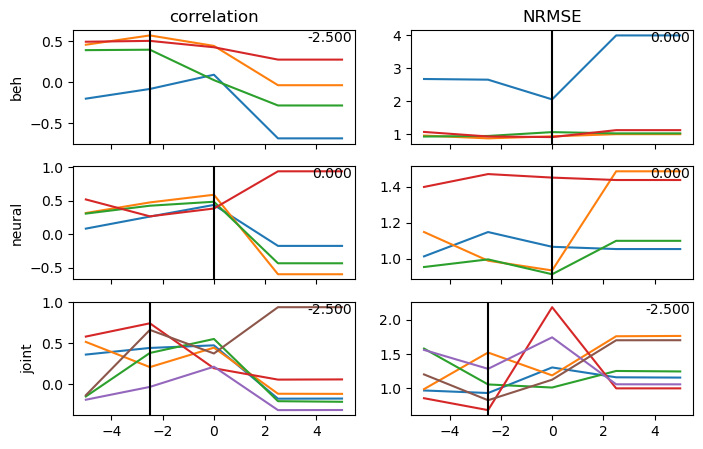

In [22]:
%%time

fig, axs = None, None
for x in binary_search_range(-5, 5, n_samples=5, tried=tried):
    parameters = dict(prp.PipelineRun.default_parameter_values['zong22'])
    parameters['neural_scale'] = 1/1000
    parameters['neural_lag'] = 0
    parameters['exit_time'] = -1
    parameters['sub_dataset_identifier'] = 3
    parameters['bw_step'] = 10**0.138
    run = prp.PipelineRun(**parameters)
    runs.append(run)
    tried.append(x)
    
    fig, axs = prp.PipelineRun.compare_metrics_across_runs(tried, runs, fig, axs)
    display.clear_output(wait=True)
    display.display(fig)



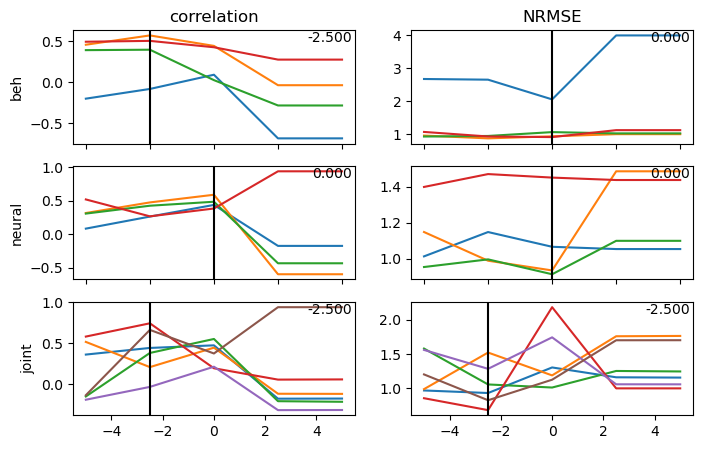

In [41]:
%matplotlib inline
reload(prp)
fig, axs = prp.PipelineRun.compare_metrics_across_runs(tried, runs);
# fig

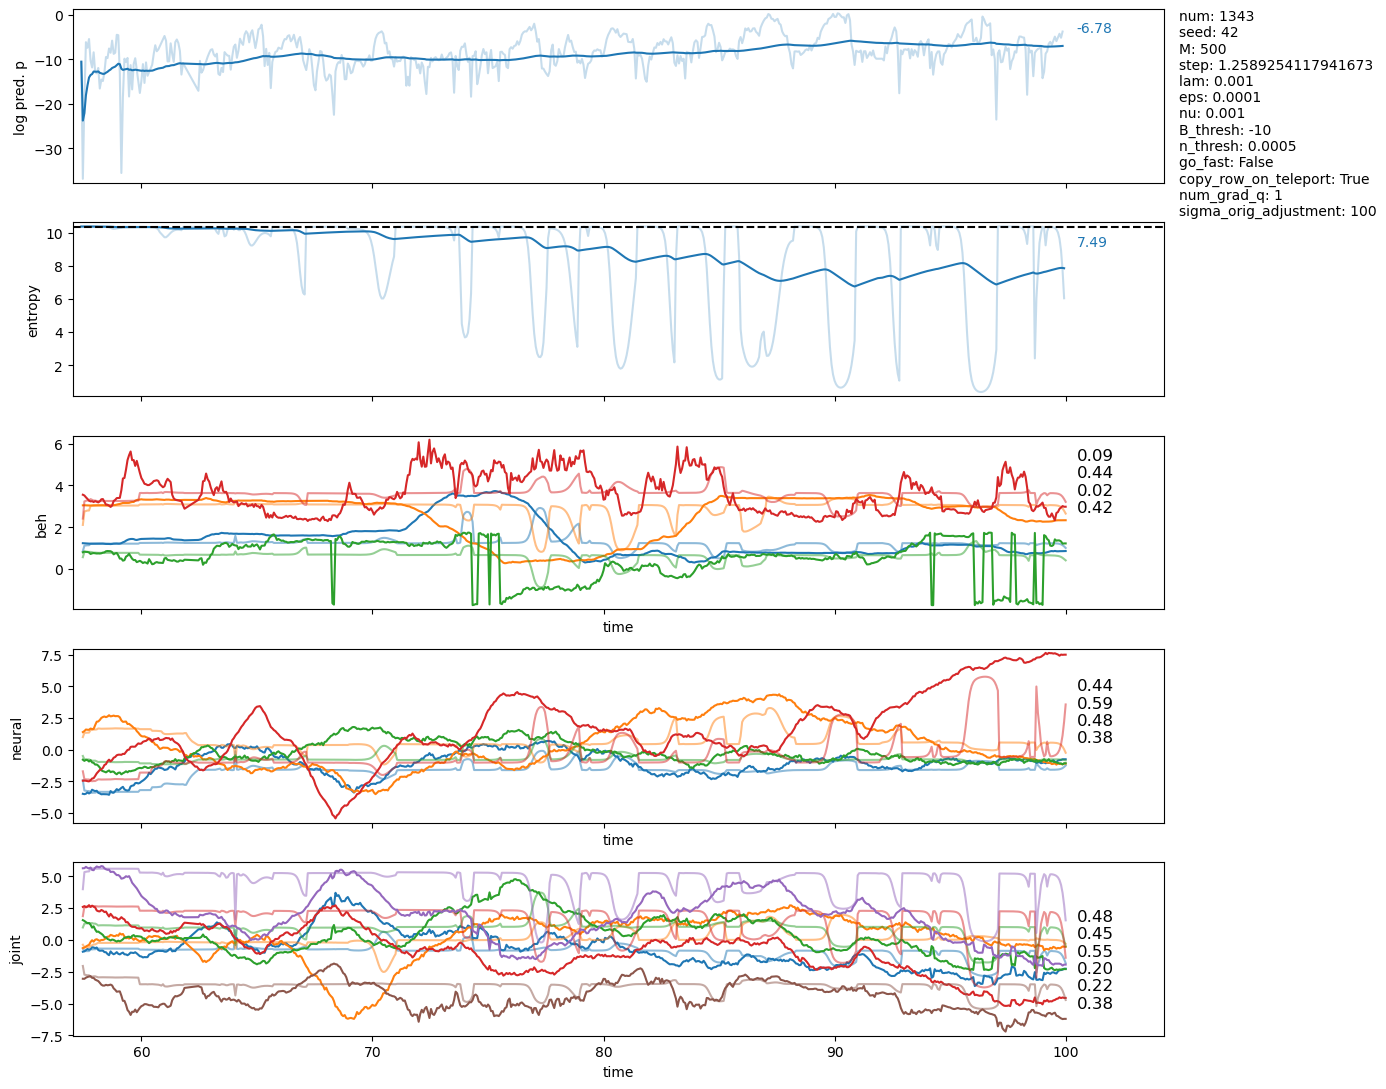

In [47]:

runs[2].plot_results()


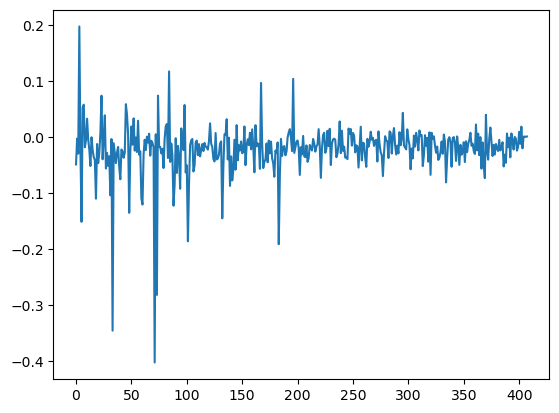

In [24]:
plt.plot(run.pro.Q[:,0])

Text(0, 0.5, 'ica')

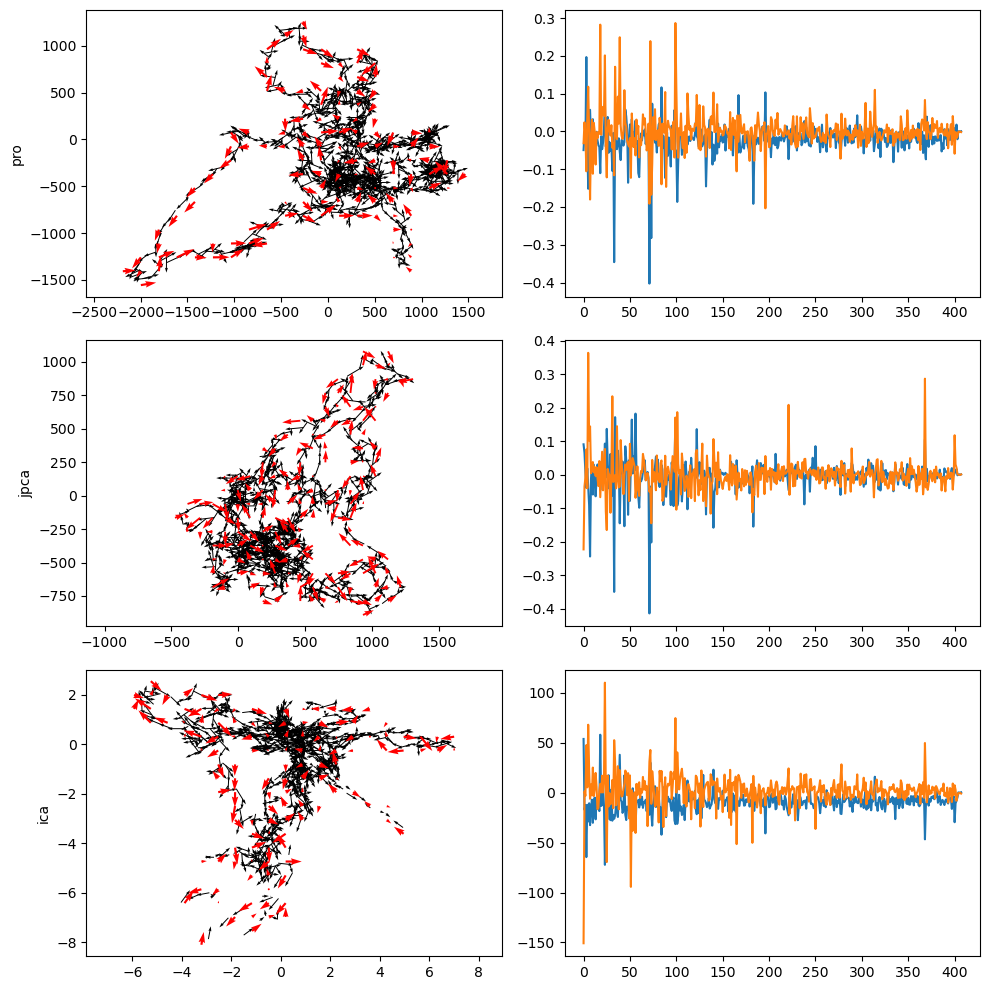

In [25]:
%matplotlib inline
 
fig, axs = plt.subplots(nrows=3, ncols=2, squeeze=False, layout='tight', figsize=(10, 10))
e1, e2 = np.zeros(6), np.zeros(6)
e1[0] = 1
e2[1] = 1

for idx, latents in enumerate([run.pro_latents, run.jpca_latents, run.ica_latents]):
    ax: plt.Axes = axs[idx, 0]
    # ax.scatter(latents[:,0], latents[:,1], s=5)

    d_latents = np.diff(latents, axis=0)
    d_latents = d_latents / np.linalg.norm(d_latents, axis=1)[:, np.newaxis]
    ax.quiver(latents[:-1] @ e1, latents[:-1]@e2, d_latents@e1, d_latents@e2, scale=1 / 20, units='dots', alpha=1)
    x1, x2, y1, y2 = ax.axis()
    x_points = np.linspace(x1, x2, 21)
    y_points = np.linspace(y1, y2, 21)
    # mgrid = np.meshgrid(*[np.linspace(latents[:, i].min(), latents[:, i].max(), 10) for i in range(2)])
    origins = []
    arrows = []
    for i in range(len(x_points) - 1):
        for j in range(len(y_points) - 1):
            proj_1 = (latents[:-1] @ e1)
            proj_2 = (latents[:-1] @ e2)
            s = (x_points[i] <= proj_1) & (proj_1 < x_points[i + 1]) & (y_points[j] <= proj_2) & (
                    proj_2 < y_points[j + 1])
            if s.sum():
                arrow = d_latents[s].mean(axis=0)
                arrow = arrow / np.linalg.norm(arrow)
                arrows.append(arrow)
                origins.append([x_points[i:i + 2].mean(), y_points[j:j + 2].mean()])
    origins, arrows = np.array(origins), np.array(arrows)
    ax.quiver(origins[:, 0], origins[:, 1], arrows @ e1, arrows @ e2, scale=1 / 20, units='dots', color='red')

    ax.axis('equal')

axs[0, 1].plot(run.pro.inverse_transform(e1, 2))
axs[0, 1].plot(run.pro.inverse_transform(e2, 2))
axs[0, 0].set_ylabel('pro')

axs[1, 1].plot(run.pro.inverse_transform(run.jpca.inverse_transform(e1, 2), 2))
axs[1, 1].plot(run.pro.inverse_transform(run.jpca.inverse_transform(e2, 2), 2))
axs[1, 0].set_ylabel('jpca')

axs[2, 1].plot(run.pro.inverse_transform(run.ica.inverse_transform(e1, 2), 2))
axs[2, 1].plot(run.pro.inverse_transform(run.ica.inverse_transform(e2, 2), 2))
axs[2, 0].set_ylabel('ica')

6


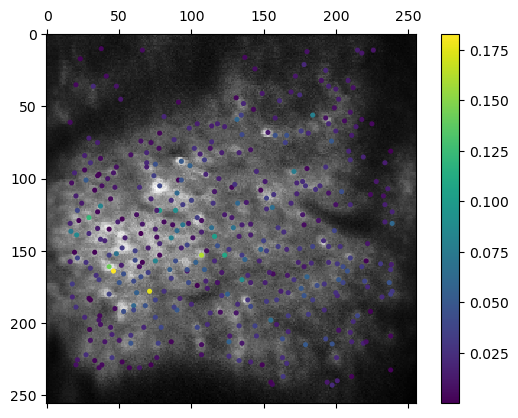

In [26]:
if isinstance(run.d, datasets.Zong22Dataset):
    desired_pattern = np.mean(latents[-101:-1], axis=0)
    current_pattern = latents[-1]
    desired_stim = desired_pattern - current_pattern
    
    desired_pattern = (desired_stim @ run.pro.Q.T)[:run.d.neural_data.a.shape[-1]]
    
    near_zero = np.abs(desired_stim) < 100
    print(near_zero.sum())
    desired_stim[near_zero] = np.nan
    
    
    fig, ax = plt.subplots()
    run.d.show_stim_pattern(ax, np.abs(desired_pattern))


NameError: name 'jpca_latents' is not defined

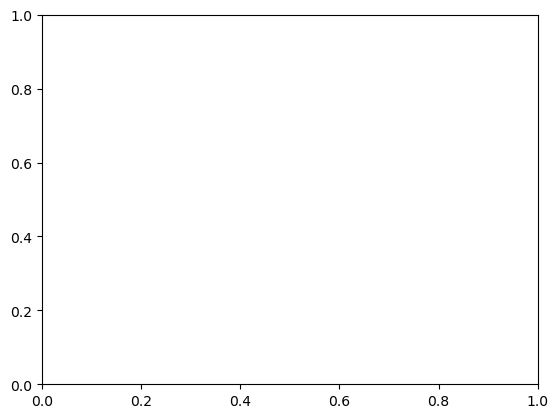

In [27]:
fig, ax = plt.subplots()

latents = jpca_latents

dim_1, dim_2 = 0,1
pf.plot_history_with_tail(ax, latents, dim_1=dim_1, dim_2=dim_2)
means = np.mean(latents, axis=0)

ax.arrow(latents[-1,dim_1], latents[-1,dim_2], means[dim_1] - latents[-1,dim_1], means[dim_2] - latents[-1,dim_2], zorder=5, head_width=.1, color='k')

ax.axis('equal');



## Intro video

In [ ]:
d = datasets.Odoherty21Dataset()

tail_length = 5  # seconds

with AnimationManager(n_cols=2, n_rows=1, figsize=(10, 5)) as am:
    for current_t in np.linspace(100, 110, 51):
        am.axs[0,0].cla()

        n_columns = np.floor(tail_length / d.bin_width).astype(int)
        idx = np.nonzero(~(d.neural_data.t < current_t))[0][0]
        
        
        am.axs[0,0].imshow(d.neural_data.a[idx-n_columns:idx,0,:].T, aspect='auto', interpolation='none', extent=[current_t - tail_length, current_t, d.neural_data.a.shape[2], 0])



        old_lims = am.axs[0,1].axis()
        am.axs[0,1].cla()
        am.axs[0,1].axis('off')
        
        s = ((current_t - tail_length) < d.behavioral_data.t) & (d.behavioral_data.t < current_t)
        am.axs[0,1].plot(d.behavioral_data.a[s,0,0], d.behavioral_data.a[s,0,1])
        pf.use_bigger_lims(am.axs[0,1], old_lims)
        
        am.grab_frame()